In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from eofs.xarray import Eof
from scipy.stats import linregress
import matplotlib.gridspec as gridspec

In [130]:
# Load data
SLP_paths = glob.glob('/pscratch/sd/s/skygale/observations/slp-regrid/*')

data_list = []
for path in SLP_paths:
    ds = xr.open_dataset(path).DATA
    data_list.append(ds)

combined = xr.concat(data_list, dim='stack')
ds = combined.mean(dim='stack')

# Define lats and lons
lat, lon = ds['lat'], ds['lon']

# Define trend lengths and final year
trend_lengths = [43, 40, 20, 10]
end_year = 42

In [137]:
def compute_trend(data):
    time = np.arange(data.shape[0])
    trend = np.full(data.shape[1:], np.nan)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            y = data[:, i, j]
            if np.any(np.isnan(y)):
                continue
            slope, _, _, _, _ = linregress(time, y)
            trend[i, j] = slope * 10 / 100  # hPa/decade
    return trend


def run_eof_analysis(data, lat, lon, n_modes, detrend):
    time = np.arange(data.shape[0])

    if detrend:
        detrended = np.empty_like(data)
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                y = data[:, i, j]
                if np.any(np.isnan(y)):
                    detrended[:, i, j] = np.nan
                else:
                    p = np.polyfit(time, y, deg=1)
                    detrended[:, i, j] = y - (p[0] * time + p[1])
    else:
        detrended = data

    da = xr.DataArray(
        detrended,
        dims=["time", "lat", "lon"],
        coords={"time": time, "lat": lat, "lon": lon}
    )

    solver = Eof(da)
    eofs = solver.eofsAsCorrelation(neofs=n_modes)
    pcs = solver.pcs(npcs=n_modes, pcscaling=1)
    varfrac = solver.varianceFraction()
    return eofs, pcs, varfrac


def plot_summary_panel(trend, eofs, pcs, variance_fractions, lon, lat,
                       trend_title, trend_cbar_label, eof_cbar_label,
                       trend_cmap, eof_cmap,
                       trend_levels, eof_levels):
    lon = np.asarray(lon)
    lat = np.asarray(lat)
    fig = plt.figure(figsize=(21, 16))
    gs = gridspec.GridSpec(3, 3, height_ratios=[0.5, 0.6, 0.2], hspace=0.1, wspace=0.15)

    # A) Trend Map
    ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.NorthPolarStereo())
    trend_cyclic, lon_cyclic = add_cyclic_point(trend, coord=lon)
    lon2d, lat2d = np.meshgrid(lon_cyclic, lat)
    ax0.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    ax0.coastlines()
    ax0.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5)
    im0 = ax0.contourf(lon2d, lat2d, trend_cyclic, transform=ccrs.PlateCarree(),
                       cmap=trend_cmap, levels=trend_levels, extend='both')
    ax0.set_title("A) " + trend_title, fontsize=16)
    cbar0 = fig.colorbar(im0, ax=ax0, orientation='vertical', shrink=0.9)
    cbar0.set_label(trend_cbar_label, fontsize=14)
    cbar0.ax.tick_params(axis='y', labelsize=14)

    # B) Variance Explained (Line Plot)
    ax1 = fig.add_subplot(gs[0, 1:])
    var_pct = variance_fractions[:10] * 100
    ax1.plot(np.arange(1, len(var_pct)+1), var_pct, marker='.', color='k')
    ax1.set_title("B) Variance (%) Explained by EOFs", fontsize=16)
    # ax1.set_xlabel("EOF", fontsize=14)
    # ax1.set_ylabel("Variance (%)", fontsize=14)
    ax1.set_xticks(np.arange(1, len(var_pct)+1))
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Match the height of ax1 to ax0
    pos0 = ax0.get_position()
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos0.y0, pos1.width, pos0.height])

    # C), D), E) — EOF Maps
    for i in range(3):
        ax = fig.add_subplot(gs[1, i], projection=ccrs.NorthPolarStereo())
        eof_data = eofs[i].values if hasattr(eofs, 'values') else eofs[i]
        eof_cyclic, lon_cyclic = add_cyclic_point(eof_data, coord=lon)
        lon2d, lat2d = np.meshgrid(lon_cyclic, lat)
        ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.gridlines(draw_labels=False, linewidth=0.3, color='k', alpha=0.5)
        cf = ax.contourf(lon2d, lat2d, eof_cyclic, transform=ccrs.PlateCarree(),
                         cmap=eof_cmap, levels=eof_levels, extend='both')
        pct = variance_fractions[i] * 100
        ax.set_title(f"{chr(67+i)}) EOF {i+1} ({pct:.1f}%)", fontsize=16, loc='left')

    # PC time series (bottom row)
    end = 42 + 1980
    start = end - length + 1
    years = np.arange(start, end+1, 1)
    
    for i in range(3):
        ax = fig.add_subplot(gs[2, i])
        pc = pcs[:, i].values if hasattr(pcs, 'values') else pcs[:, i]
        colors = ['red' if val > 0 else 'blue' for val in pc]

        ax.bar(years, pc, color=colors, width=0.8)
        ax.axhline(0, color='k', linewidth=0.5)
        ax.set_xlim(years[0], years[-1])
        ax.set_ylim(-2, 2)
        ax.set_title(f"{chr(70+i)}) PC {i+1}", fontsize=16, loc='left')
        ax.set_xticks(np.arange(years[0], years[-1]+1, 5))
        ax.tick_params(labelsize=14)
        if i == 0:
            ax.set_ylabel('Standardized')

    # Shared colorbar for EOFs
    cbar_ax = fig.add_axes([0.21, 0.045, 0.6, 0.025])  # [left, bottom, width, height]
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(eof_cbar_label, fontsize=14)
    cbar.ax.tick_params(axis='x', labelsize=14)

    plt.savefig(f'./figures/{trend_title}_Detrended.png', dpi=300)
    plt.show()

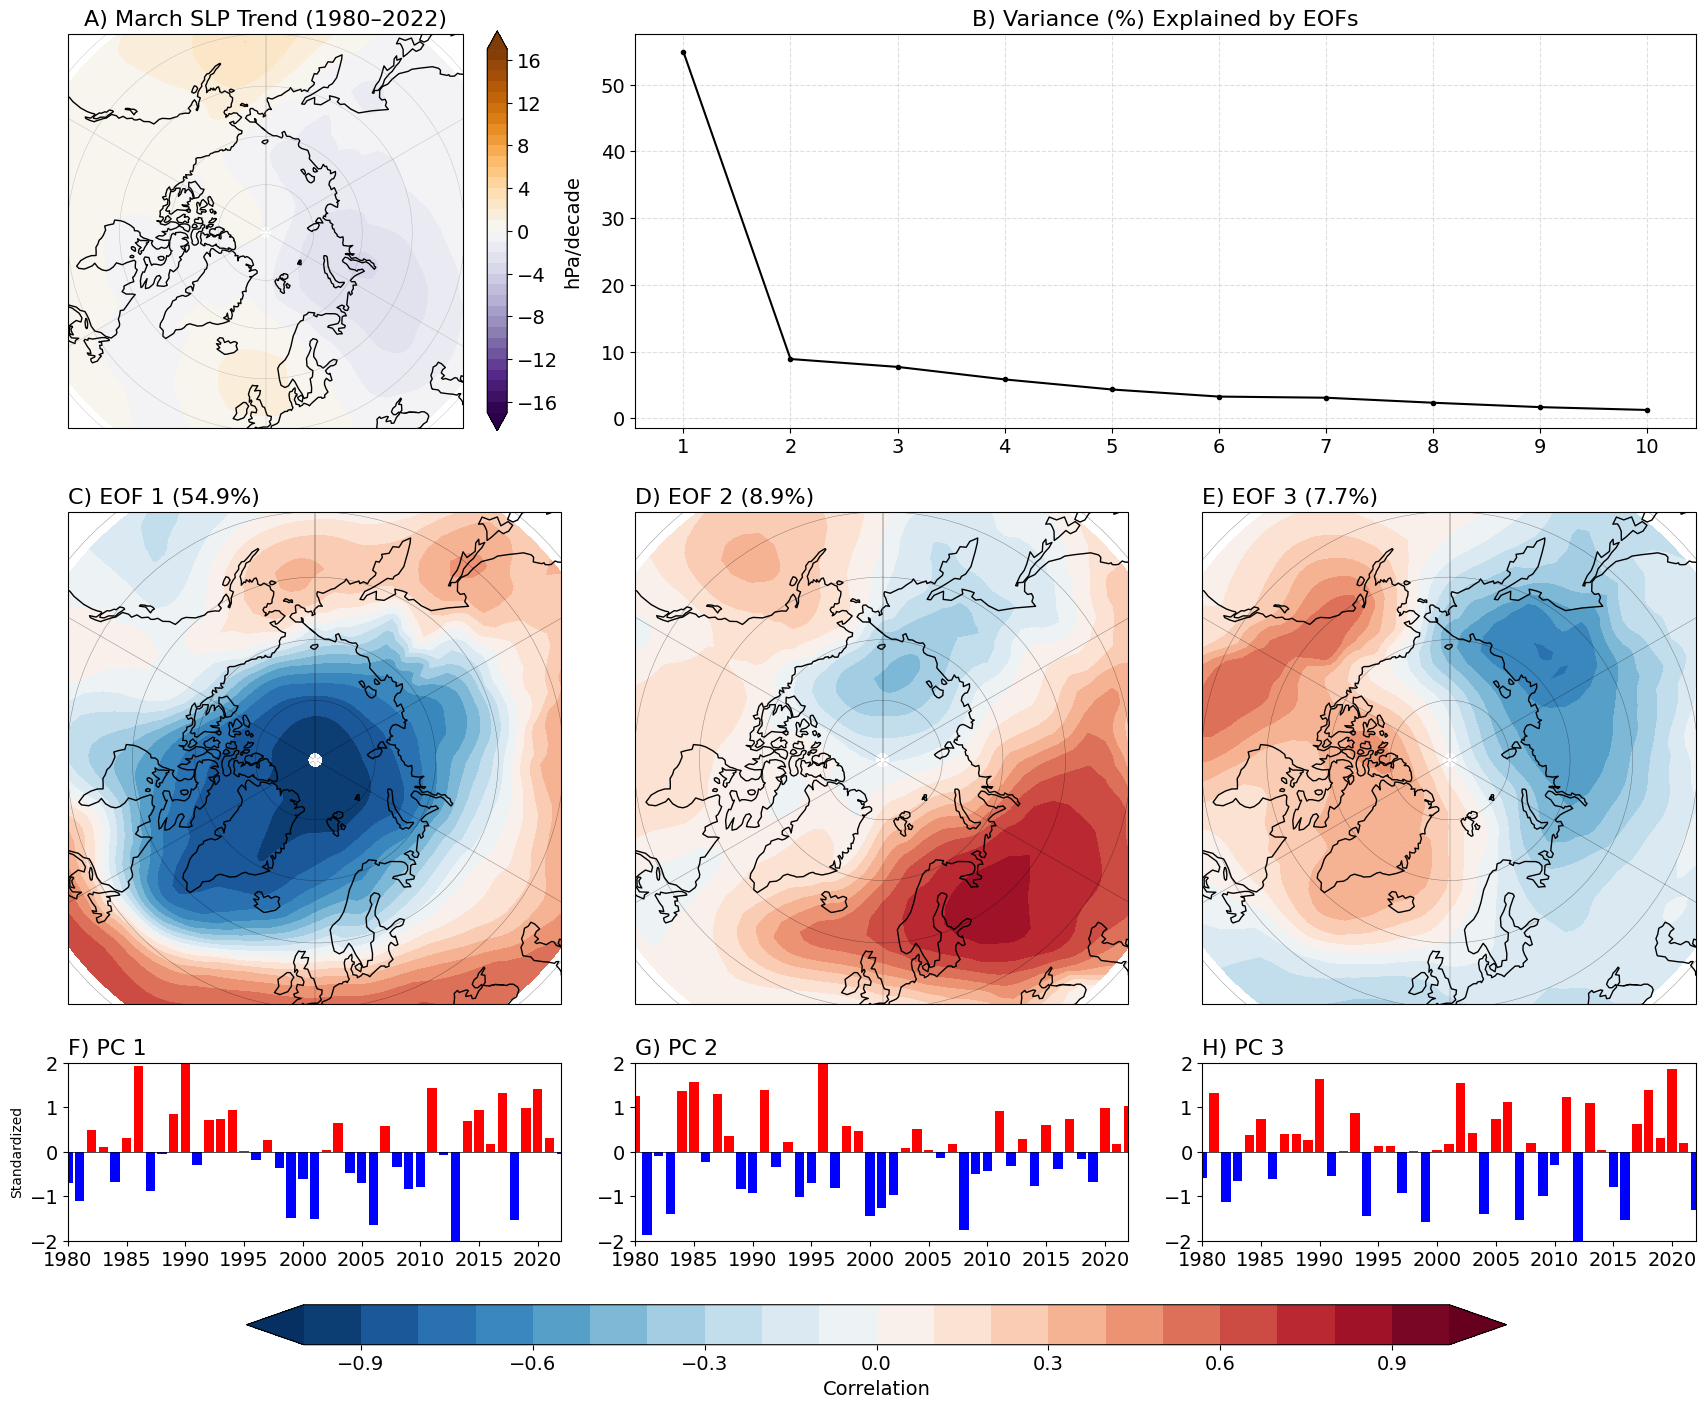

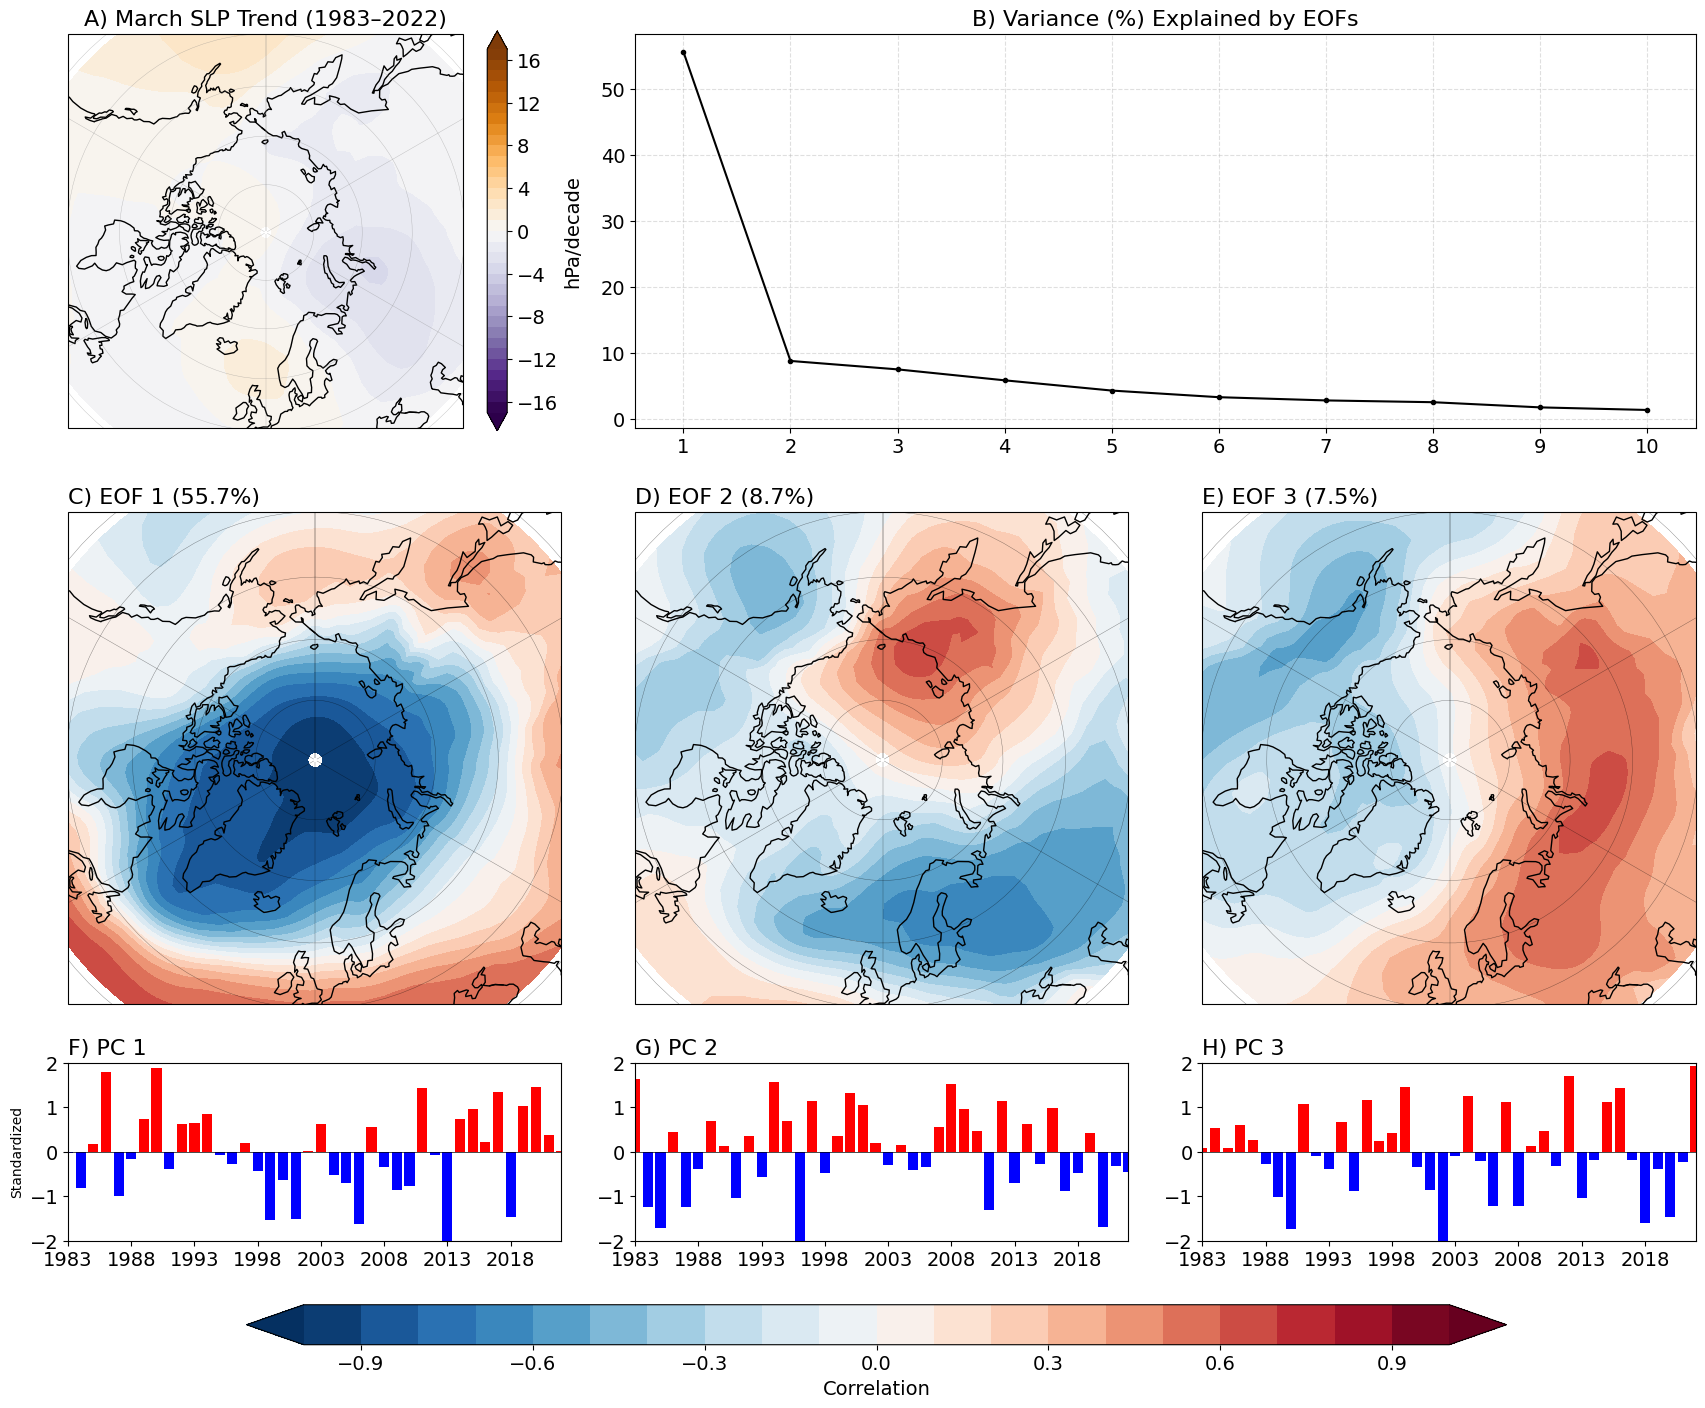

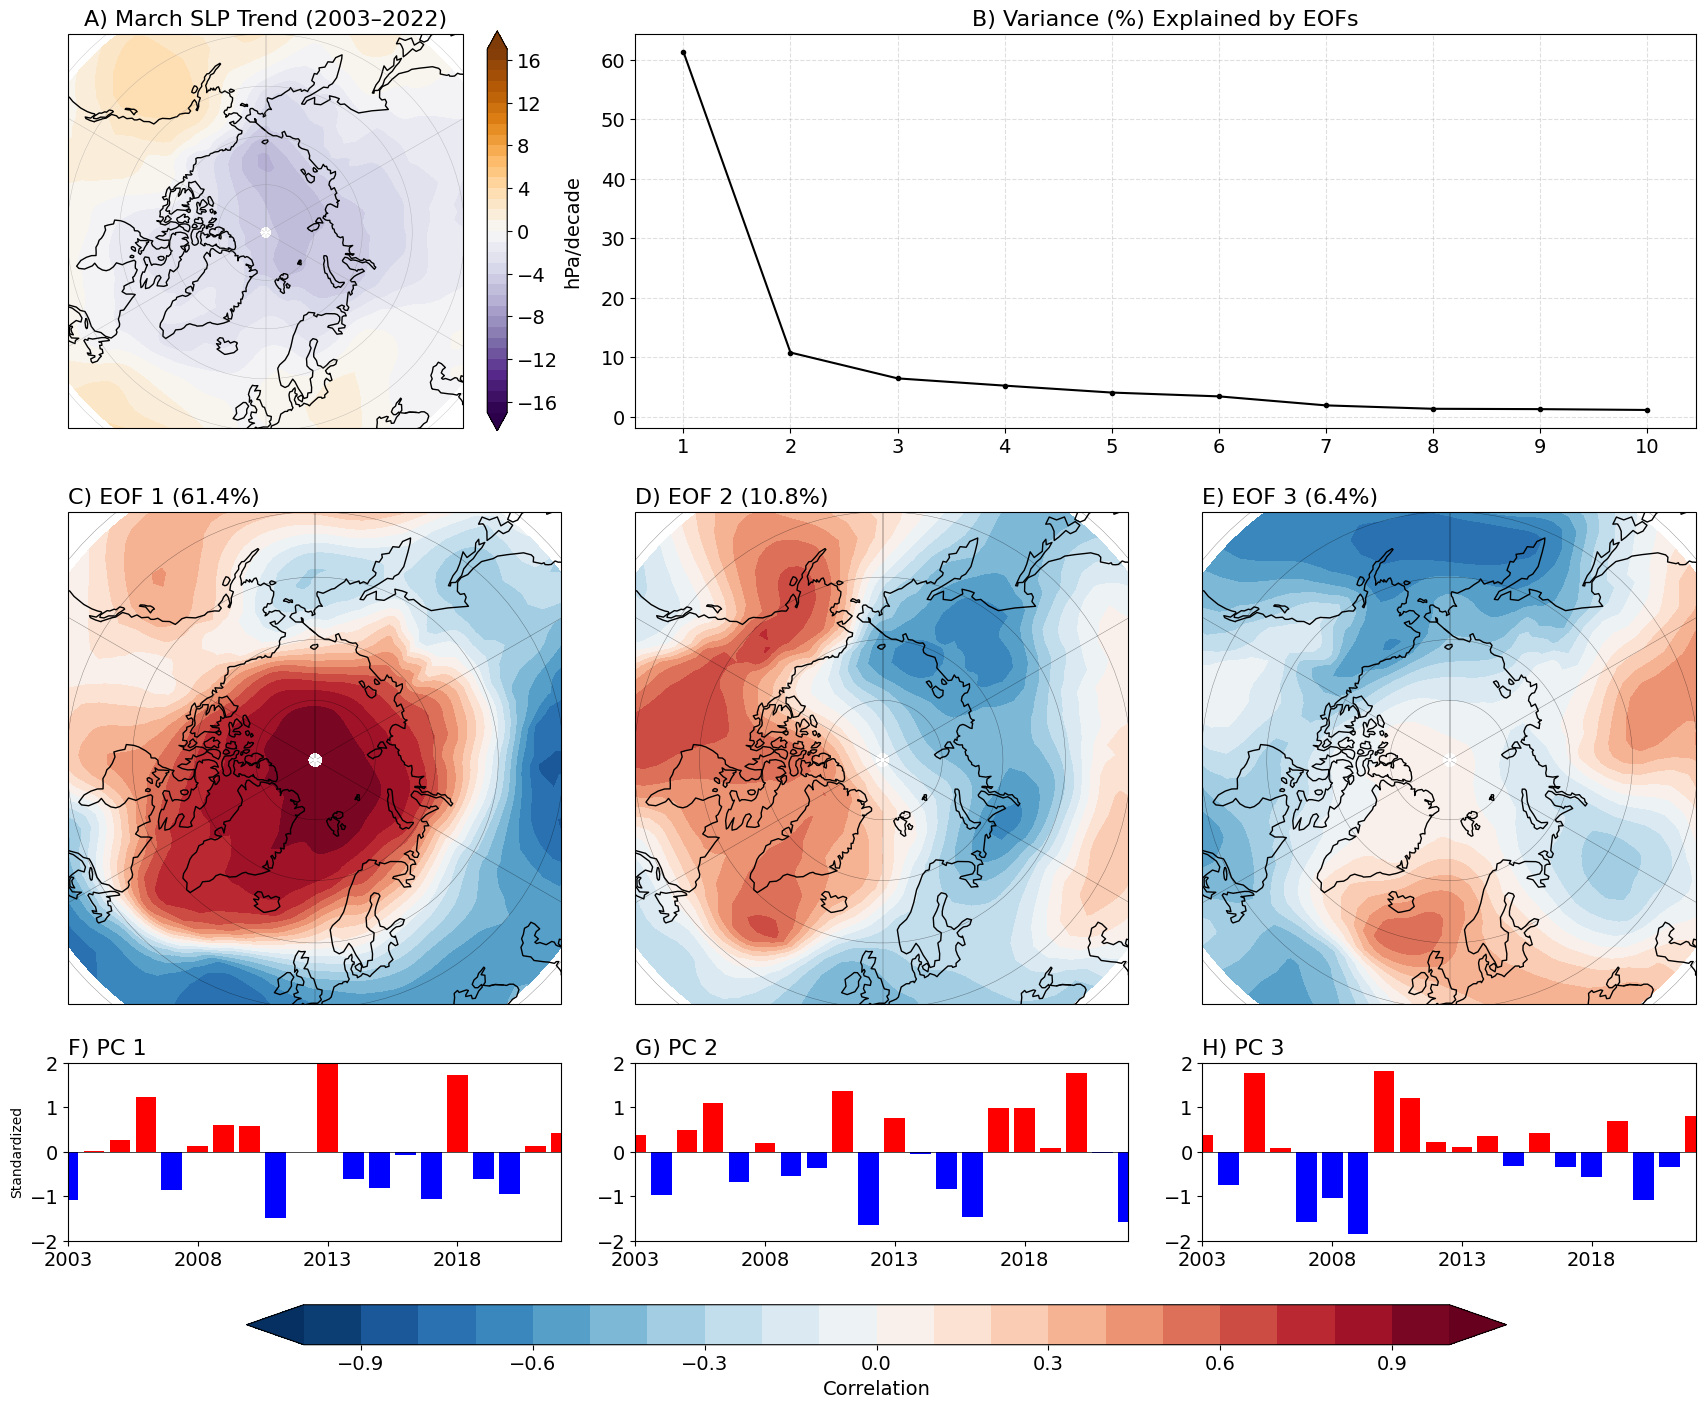

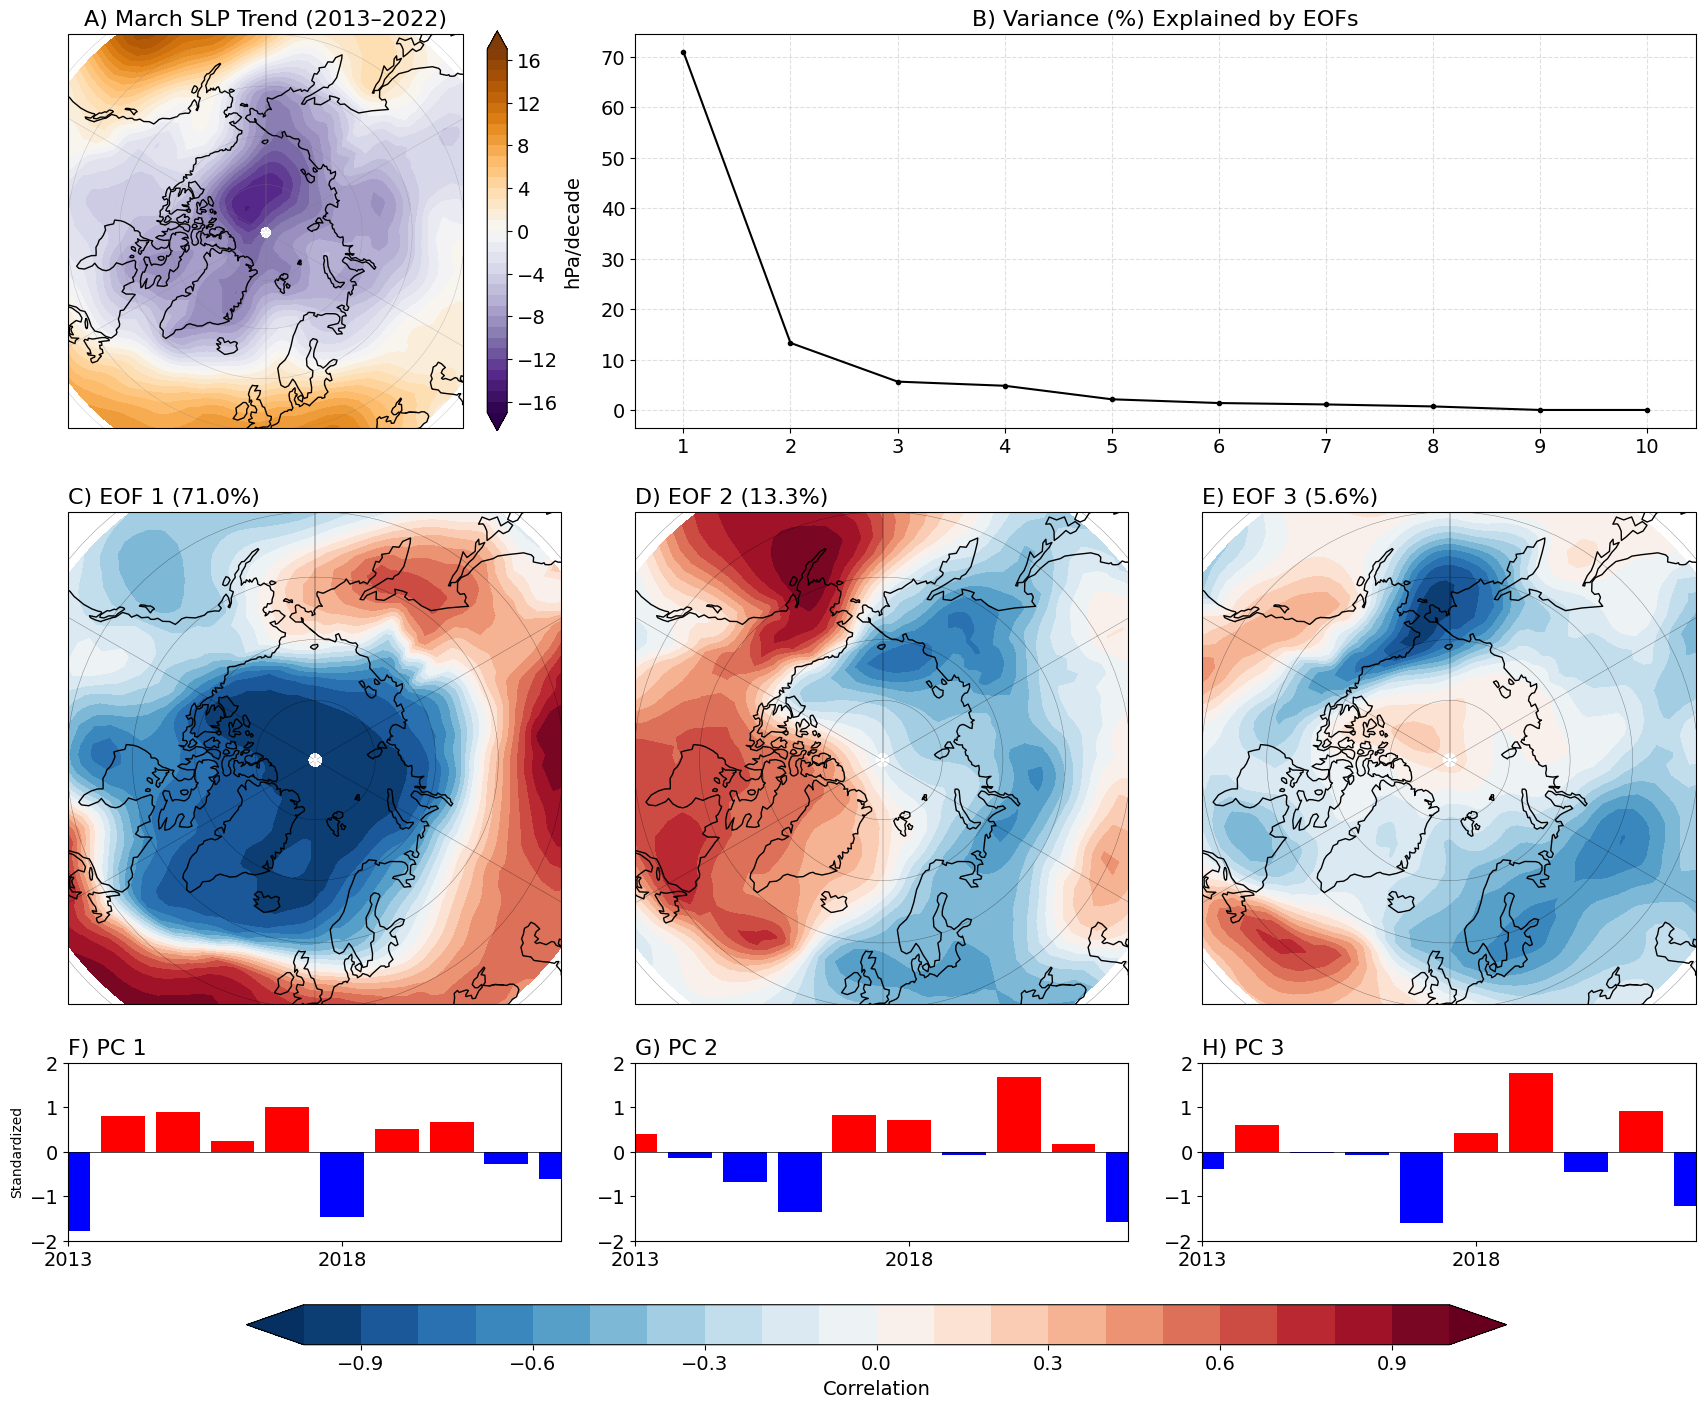

In [138]:
for length in trend_lengths:
    # March = 0, April = 1, May = 2
    start_year = end_year - length + 1
    data = ds.sel(year=slice(start_year, end_year)).sel(lat=ds.lat>=40).isel(month=0)

    # Compute trend and run EOF analysis
    trend = compute_trend(data)
    eofs, pcs, varfrac = run_eof_analysis(data, lat=lat[8:], lon=lon, n_modes=3, detrend=True)

    # Plot summary
    plot_summary_panel(
        trend, eofs, pcs, varfrac, lon, lat[8:],
        trend_title=f"March SLP Trend ({start_year+1980}–{end_year+1980})",
        trend_cbar_label="hPa/decade",
        eof_cbar_label="Correlation",
        trend_cmap='PuOr_r',
        eof_cmap='RdBu_r',
        trend_levels=np.arange(-17, 18, 1),
        eof_levels=np.linspace(-1, 1, 21)
    )

    print('\n\n\n')